In [11]:

import os
import math
import json
import argparse
import time
import torch
from datasets import load_dataset
import torch.nn as nn
import numpy as np
from utils_oke import SNR_to_noise, val_step_with_smart_simple_JSCC,  train_step_modulated_budget, train_step_modulated_adv, train_step_router_budget_v3
#type 1 transmit a bunch
# from models_2.transceiver_JSCC_type_1 import JSCC_DeepSC

#type 2 transmit only the CLS
from models_2.transceiver_modulation_JSCC_type_2_oke import  MODJSCC_MoE_Faithful_2
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
import torch
torch.autograd.set_detect_anomaly(True)

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
parser = argparse.ArgumentParser()

parser.add_argument('--checkpoint-path', default='/home/necphy/ducjunior/RoBERTa_MoE/checkpoints/JSSC_MoE_new_loss_better_router_2', type=str)
# parser.add_argument('--loadcheckpoint-path', default='/home/necphy/ducjunior/BERT_Backdoor/checkpoints/deepsc_v12_sanity', type=str)
parser.add_argument('--channel', default='AWGN', type=str, help = 'Please choose AWGN, Rayleigh, and Rician')
parser.add_argument('--d-model', default=256, type=int)
# parser.add_argument('--dff', default=512, type=int)
parser.add_argument('--batch-size', default=256, type=int)
parser.add_argument('--epochs', default=5, type=int)
parser.add_argument('--alpha', default=1, type=float)
parser.add_argument('--lambda_rate', default=.001, type=float)
parser.add_argument('--lambda_M', default=.1, type=float)
parser.add_argument('--lambda_mod', default=.05, type=float)


args = parser.parse_args([])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [12]:
import math
def discrete_probability(y_tilde: torch.Tensor,
                         mu: torch.Tensor,
                         sigma: torch.Tensor,
                         eps: float = 1e-12) -> torch.Tensor:
    # y_tilde, mu, sigma: [B, D]
    # print(y_tilde.shape)
    # print(mu.shape)
    lower = (y_tilde - 0.5 - mu) / (sigma * math.sqrt(2))
    upper = (y_tilde + 0.5 - mu) / (sigma * math.sqrt(2))
    p = 0.5 * (torch.erf(upper) - torch.erf(lower))
    
    return p.clamp(min=eps)

In [13]:
import math, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

@torch.no_grad()
def _constant_snr_seq(batch_size, T, snr_db, device):
    """Constant per-frame SNR sequence (linear γ) at a given snr_db."""
    gamma = (10.0 ** (snr_db / 10.0))
    return torch.full((batch_size, T), gamma, device=device, dtype=torch.float32)

@torch.no_grad()
def validate_at_snr(model, dataloader, snr_db: float, channel: str, device,
                    use_ar1=False, coherence_frames=3.0, sigma_db=1.0):
    """
    Time-unrolled validation at a fixed SNR point.
    Returns:
      dict(snr_db, acc, avg_rate_bits, expert_hist, N)
    Notes:
      - Builds snr_seq [B,T] and uses mean γ across frames to set one AWGN variance per burst.
      - avg_rate_bits is recomputed TX-side from (encoder, hyper-encoder/decoder) to match training.
      - expert_hist counts per-frame hard routes, masked by frame_mask (only used frames).
    """
    model.eval()
    T = getattr(model, "T_max", 6)

    total_correct = 0
    total_samples = 0
    sum_rate_bits = 0.0

    # expert usage histogram (over frames actually used)
    E = len(model.bps_list)
    expert_counts = torch.zeros(E, dtype=torch.long)

    for batch in dataloader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["label"].to(device)
        B = input_ids.size(0)

        # --- per-frame SNR sequence ---
        if use_ar1:
            # small dB wobble around snr_db mean (AR(1) in dB)
            mu_db = snr_db
            rho = math.exp(-1.0 / max(coherence_frames, 1e-6))
            x = torch.full((B, T), mu_db, device=device)
            # init exactly at mean
            if T > 1:
                for t in range(1, T):
                    eps = torch.randn(B, device=device)
                    x[:, t] = mu_db + rho * (x[:, t-1] - mu_db) + sigma_db * math.sqrt(max(1e-8, 1.0 - rho**2)) * eps
            snr_seq = (10.0 ** (x / 10.0))
        else:
            snr_seq = _constant_snr_seq(B, T, snr_db, device)  # [B,T]

        # one variance per burst from mean γ across frames
        n_var = (1.0 / snr_seq.mean(dim=1)).to(torch.float32)  # [B]

        # --- forward (time-unrolled) ---
        logits, rate_bits_rx, _route_legacy, _Ns_eff, sched = model(
            input_ids, attention_mask, n_var, channel, snr_seq=snr_seq
        )

        # predictions
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += B

        # --- expert usage over frames actually used ---
        # hard indices [B,T], frame_mask [B,T] in {0,1}
        z_idx = sched.get("z_idx")                         # [B,T]
        frame_mask = sched.get("frame_mask")               # [B,T] (might be all-ones if not set)
        if z_idx is None:
            # fallback: derive from hard one-hots if needed
            z_idx = sched["z_seq"].argmax(dim=-1)
        if frame_mask is None:
            frame_mask = torch.ones_like(z_idx, dtype=torch.float32)

        # count only used frames
        used_idx = z_idx[frame_mask > 0.5].reshape(-1).detach().cpu()
        if used_idx.numel() > 0:
            expert_counts += torch.bincount(used_idx, minlength=E)

        # --- recompute TX-side rate bits to match training proxy ---
        # (use encoder + hyper-enc/dec; evaluate with rounding)
        y = model.encoder(input_ids, attention_mask)                      # [B,d_model]
        logsnr = torch.log(1.0 / n_var).view(-1, 1)                       # [B,1]
        z = model.hyper_encoder(torch.cat([y, logsnr], dim=1))            # [B,d_model]
        y_tilde = y.round()
        z_tilde = z.round()
        raw_sigma = model.hyper_decoder(z_tilde)                           # [B,d_model]
        sigma_tx = F.softplus(raw_sigma) + 1e-6

        p_y = discrete_probability(y_tilde, torch.zeros_like(y_tilde), sigma_tx)
        rate_y = -torch.log2(p_y.clamp_min(1e-9)).sum(dim=1)              # [B]
        p_z = discrete_probability(z_tilde, torch.zeros_like(z_tilde), torch.ones_like(z_tilde))
        rate_z = -torch.log2(p_z.clamp_min(1e-9)).sum(dim=1)              # [B]
        rate_bits = rate_y + rate_z
        sum_rate_bits += rate_bits.sum().item()

    acc = total_correct / max(total_samples, 1)
    avg_rate_bits = sum_rate_bits / max(total_samples, 1)
    return {
        "snr_db": snr_db,
        "acc": acc,
        "avg_rate_bits": avg_rate_bits,
        "expert_hist": expert_counts.tolist(),
        "N": total_samples,
    }

@torch.no_grad()
def sweep_snr(model, dataset, batch_size, device, channel="AWGN",
              snr_grid_db=None, num_workers=2, use_ar1=False, coherence_frames=3.0, sigma_db=1.0):
    """
    Sweeps SNR points and validates with the time-unrolled model.
    Set use_ar1=True to add small temporal wobble within each burst.
    """
    if snr_grid_db is None:
        snr_grid_db = [0, 2, 4, 6, 8, 10, 12]

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        drop_last=False, num_workers=num_workers)

    results = []
    for snr_db in snr_grid_db:
        metrics = validate_at_snr(model, loader, snr_db, channel, device,
                                  use_ar1=use_ar1, coherence_frames=coherence_frames, sigma_db=sigma_db)
        results.append(metrics)
        print(f"[SNR {snr_db:>2} dB]  acc={metrics['acc']:.4f}  "
              f"avg_rate_bits={metrics['avg_rate_bits']:.1f}  "
              f"experts={metrics['expert_hist']}")
    return results


In [14]:
import csv
import matplotlib.pyplot as plt

In [15]:
def save_results(results, out_dir="results", run_name="run"):
    os.makedirs(out_dir, exist_ok=True)
    # JSON for full fidelity
    with open(os.path.join(out_dir, f"{run_name}_snr_sweep.json"), "w") as f:
        json.dump(results, f, indent=2)
    # CSV for quick spreadsheet checks
    E = len(results[0]["expert_hist"])
    header = ["snr_db", "acc", "avg_rate_bits"] + [f"expert_{i}" for i in range(E)]
    with open(os.path.join(out_dir, f"{run_name}_snr_sweep.csv"), "w", newline="") as f:
        w = csv.writer(f); w.writerow(header)
        for r in results:
            row = [r["snr_db"], r["acc"], r["avg_rate_bits"]] + r["expert_hist"]
            w.writerow(row)

def plot_acc(results, out_dir="results", run_name="run"):
    xs = [r["snr_db"] for r in results]
    ys = [r["acc"] for r in results]
    plt.figure()
    plt.plot(xs, ys, marker="o")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs SNR")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{run_name}_acc_vs_snr.png"), dpi=180)
    plt.close()

def plot_rate(results, out_dir="results", run_name="run"):
    xs = [r["snr_db"] for r in results]
    ys = [r["avg_rate_bits"] for r in results]
    plt.figure()
    plt.plot(xs, ys, marker="o")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Avg compression rate (bits)")
    plt.title("Average Rate vs SNR")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{run_name}_rate_vs_snr.png"), dpi=180)
    plt.close()

def plot_expert_usage(results, out_dir="results", run_name="run"):
    xs = [r["snr_db"] for r in results]
    E = len(results[0]["expert_hist"])
    # Normalize to fractions per SNR
    fracs = []
    for r in results:
        counts = r["expert_hist"]
        total = max(sum(counts), 1)
        fracs.append([c/total for c in counts])  # [E]
    fracs = list(zip(*fracs))  # E x len(xs)

    plt.figure()
    bottom = [0.0] * len(xs)
    for e in range(E):
        plt.bar(xs, fracs[e], bottom=bottom, label=f"{2**(e+2)}QAM")
        bottom = [b + f for b, f in zip(bottom, fracs[e])]
    plt.xlabel("SNR (dB)")
    plt.ylabel("Usage fraction")
    plt.title("Expert usage vs SNR")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{run_name}_experts_vs_snr.png"), dpi=180)
    plt.close()


In [16]:
import os
import matplotlib
# matplotlib.use("TkAgg")  # or "Qt5Agg"
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_paths = [
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf",
    ]
for p in font_paths:
        if os.path.exists(p):
            fm.fontManager.addfont(p)
plt.rcParams['font.family']    = 'serif'
plt.rcParams['font.serif']     = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize']= 20
plt.rcParams['ytick.labelsize']= 20
plt.rcParams['legend.fontsize']= 22
plt.rcParams['pdf.fonttype']   = 42
plt.rcParams['ps.fonttype']    = 42


def plot_acc_matplotlib(results, out_dir="results", run_name="run"):
    os.makedirs(out_dir, exist_ok=True)
    xs = [r["snr_db"] for r in results]
    ys = [r["acc"] for r in results]
    plt.figure()
    plt.plot(xs, ys, marker="o")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs SNR")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
    # plt.savefig(os.path.join(out_dir, f"{run_name}_acc_vs_snr.png"), dpi=180)
    # plt.close()
from pathlib import Path
def plot_rate_matplotlib(results, out_dir="results", run_name="run"):
    os.makedirs(out_dir, exist_ok=True)
    xs = [r["snr_db"] for r in results]
    ys = [r["avg_rate_bits"] for r in results]
    plt.figure()
    plt.plot(xs, ys, marker="o")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Avg compression rate (bits)")
    plt.title("Average Rate vs SNR")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
    # plt.savefig(os.path.join(out_dir, f"{run_name}_rate_vs_snr.png"), dpi=180)
    # plt.close()

def plot_expert_usage_matplotlib(results, out_dir="results", run_name="run"):
    os.makedirs(out_dir, exist_ok=True)
    xs = [r["snr_db"] for r in results]
    E = len(results[0]["expert_hist"])
    # normalize to fractions at each SNR
    fracs = []
    for r in results:
        counts = r["expert_hist"]
        tot = max(sum(counts), 1)
        fracs.append([c / tot for c in counts])
    # transpose: E x len(xs)
    fracs = list(zip(*fracs))

    plt.figure()
    bottom = [0.0] * len(xs)
    for e in range(E):
        plt.bar(xs, fracs[e], bottom=bottom, label=f"Expert {e}")
        bottom = [b + f for b, f in zip(bottom, fracs[e])]
    plt.xlabel("SNR (dB)")
    plt.ylabel("Usage fraction")
    plt.title("Expert usage vs SNR")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.savefig(os.path.join(out_dir, f"{run_name}_experts_vs_snr.png"), dpi=180)
    # plt.close()
def _to_pct(y):
    # accept % or [0,1]; convert to %
    y = list(y)
    return [v*100.0 if max(y) <= 1.0 else v for v in y]

def plot_acc_all_experts(acc_curves, snr_db_grid, title="Accuracy vs SNR (all experts)", save_path=None):
    """
    acc_curves: dict like {4: [..], 16: [..], 64: [..], ...} or keys as strings
    snr_db_grid: list of SNR(dB) values aligned with each accuracy list
    """
    plt.figure()
    for key, acc in acc_curves.items():
        label = f"{key}-QAM" if isinstance(key, int) else str(key)
        plt.plot(snr_db_grid, _to_pct(acc), label=label)
    plt.xlabel("SNR (dB)")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def plot_acc_per_expert(acc_curves, snr_db_grid, out_dir=None):
    """
    Makes one figure per expert (no subplots).
    """
    for key, acc in acc_curves.items():
        label = f"{key}-QAM" if isinstance(key, int) else str(key)
        plt.figure()
        plt.plot(snr_db_grid, _to_pct(acc))
        plt.xlabel("SNR (dB)")
        plt.ylabel("Accuracy (%)")
        plt.title(f"{label} Accuracy vs SNR")
        plt.grid(True)
        if out_dir:
            Path(out_dir).mkdir(parents=True, exist_ok=True)
            fname = f"acc_{key}QAM.png" if isinstance(key, int) else f"acc_{key}.png"
            plt.savefig(Path(out_dir)/fname, dpi=200, bbox_inches="tight")
        plt.show()

In [17]:
from utils_oke import PowerNormalize, Channels

def map_to_constellation(bits: torch.Tensor, M: int) -> torch.Tensor:
    """
    bits: Tensor[..., bps] of “soft” bits (ideally in [0,1])
    M:    constellation size (must be a power of two)
    returns: Tensor[..., 2] of IQ points, unit-avg-power
    """
    # no in-place ops on grad-carrying tensors
    bits = bits.to(dtype=torch.float32)
    bits = bits.clamp(0.0, 1.0)   # OUT-OF-PLACE

    bps = bits.size(-1)
    if (1 << bps) != M:
        raise ValueError(f"Constellation-size mismatch: M={M} but bits-per-symbol={bps}")

    if bps == 1:  # BPSK
        I = bits[..., 0] * 2.0 - 1.0
        Q = torch.zeros_like(I)
        return torch.stack([I, Q], dim=-1)

    # Rectangular/square QAM
    bps_I = bps // 2
    bps_Q = bps - bps_I

    def axis_int(x, nbits):
        if nbits == 0:
            return torch.zeros(x.shape[:-1], device=x.device, dtype=x.dtype)
        w = 2 ** torch.arange(nbits - 1, -1, -1, device=x.device, dtype=x.dtype)
        return (x * w).sum(dim=-1)

    I_int = axis_int(bits[..., :bps_I], bps_I)
    Q_int = axis_int(bits[..., bps_I:], bps_Q)

    L_I = float(2 ** bps_I)
    L_Q = float(2 ** bps_Q)
    I_lvl = 2.0 * I_int + 1.0 - L_I
    Q_lvl = 2.0 * Q_int + 1.0 - L_Q

    raw_power = (L_I * L_I - 1.0) / 3.0 + (L_Q * L_Q - 1.0) / 3.0
    norm = math.sqrt(raw_power) if raw_power > 1e-6 else 1.0

    return torch.stack([I_lvl / norm, Q_lvl / norm], dim=-1)

In [18]:
model_path = "/home/necphy/ducjunior/RoBERTa_MoE/checkpoints/JSCC_MoE_faith_1_64QAM/checkpoint_best.pth"#model_paths[-1]  # Load the latest checkpoint


In [19]:

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def preprocess_sst2(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=64)
ds =   load_dataset("glue", "sst2")
ds_encoded = ds.map(preprocess_sst2, batched=True)
ds_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_eur = ds_encoded["validation"]
deepsc = MODJSCC_MoE_Faithful_2(args.d_model, freeze_bert=False).to(args.device)

# model_paths = [os.path.join(args.checkpoint_path, fn) for fn in os.listdir(args.checkpoint_path) if fn.endswith('.pth')]


print("Load model path", model_path)
checkpoint = torch.load(model_path, map_location=device)
deepsc.load_state_dict(checkpoint, strict=True)

# SNR sweep on validation set
snr_grid = np.linspace(-20, 35, num=25)  # tweak as you like
val_loader_bs = args.batch_size

results = sweep_snr(
    model=deepsc,
    dataset=test_eur,
    batch_size=val_loader_bs,
    device=args.device,
    channel="AWGN",            # or "Rayleigh"/"Rician"
    snr_grid_db=snr_grid,
    num_workers=2
)

run_name = f"MoE_{args.d_model}"
out_dir = os.path.join("/home/necphy/ducjunior/RoBERTa_MoE/checkpoints/JSCC_MoE_faith_1_64QAM", "figs")
save_results(results, out_dir=out_dir, run_name=run_name)
plot_acc(results,  out_dir=out_dir, run_name=run_name)
plot_rate(results, out_dir=out_dir, run_name=run_name)
plot_expert_usage(results, out_dir=out_dir, run_name=run_name)

print(f"Saved sweep to: {out_dir}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load model path /home/necphy/ducjunior/RoBERTa_MoE/checkpoints/JSCC_MoE_faith_1_64QAM/checkpoint_best.pth
[SNR -20.0 dB]  acc=0.5401  avg_rate_bits=1827.6  experts=[932, 2791, 1032]
[SNR -17.708333333333332 dB]  acc=0.5998  avg_rate_bits=1827.6  experts=[1088, 2568, 1110]
[SNR -15.416666666666668 dB]  acc=0.6273  avg_rate_bits=1827.6  experts=[1284, 2404, 1113]
[SNR -13.125 dB]  acc=0.7248  avg_rate_bits=1827.6  experts=[1431, 2186, 1173]
[SNR -10.833333333333334 dB]  acc=0.7947  avg_rate_bits=1827.6  experts=[1603, 2014, 1196]
[SNR -8.541666666666668 dB]  acc=0.8807  avg_rate_bits=1827.6  experts=[1801, 1807, 1186]
[SNR -6.25 dB]  acc=0.9255  avg_rate_bits=1827.6  experts=[1963, 1629, 1240]
[SNR -3.9583333333333357 dB]  acc=0.9369  avg_rate_bits=1827.6  experts=[2205, 1388, 1246]
[SNR -1.6666666666666679 dB]  acc=0.9415  avg_rate_bits=1827.6  experts=[2396, 1263, 1213]
[SNR 0.625 dB]  acc=0.9427  avg_rate_bits=1827.6  experts=[2678, 1049, 1155]
[SNR 2.9166666666666643 dB]  acc=0.9415 

In [20]:
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def preprocess_sst2(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=64)
ds =   load_dataset("glue", "sst2")
ds_encoded = ds.map(preprocess_sst2, batched=True)
ds_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_eur = ds_encoded["validation"]
model = MODJSCC_MoE_Faithful_2(args.d_model, freeze_bert=False).to(args.device)

model_paths = [os.path.join(args.checkpoint_path, fn) for fn in os.listdir(args.checkpoint_path) if fn.endswith('.pth')]

# model_path = "/home/necphy/ducjunior/RoBERTa_MoE/checkpoints/JSCC_MoE_faith_1/checkpoint_best.pth"#model_paths[-1]  # Load the latest checkpoint
print("Load model path", model_path)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=True)

# SNR sweep on validation set
snr_db_grid = np.linspace(-20, 15, num=35)  # tweak as you like
acc_curves = {int(M): [] for M in model.M_list}  # {4:[...], 16:[...], ...}

model.eval()
for snr_db in snr_db_grid:
    n_var = SNR_to_noise(snr_db)

    # per-SNR accumulators
    correct_per_e = torch.zeros(len(model.M_list), device=device, dtype=torch.long)
    total = 0

    with torch.no_grad():
        for batch in DataLoader(test_eur, batch_size=256, shuffle=False,
                                drop_last=False, num_workers=2):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            out = model.probe_experts(input_ids, attention_mask, n_var,
                                      channel='AWGN', labels=None, share_noise=True)
            # logits_all: [B, C, K]
            logits_all = out["logits_all"]  # ensure probe_experts returns this
            preds = logits_all.argmax(dim=1)                 # [B, K]
            # compare each expert's preds to labels → [B, K] booleans
            matches = (preds == labels.view(-1, 1)).sum(dim=0)  # [K] counts
            correct_per_e += matches.to(device)
            total += labels.size(0)

    # append one accuracy per expert for THIS SNR
    for i, M in enumerate(model.M_list):
        acc = (correct_per_e[i].item() / total) * 100.0
        acc_curves[int(M)].append(acc)
plot_acc_all_experts(acc_curves, snr_db_grid, save_path="plots/acc_all.png")
plot_acc_per_expert(acc_curves, snr_db_grid, out_dir="plots/per_expert")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load model path /home/necphy/ducjunior/RoBERTa_MoE/checkpoints/JSCC_MoE_faith_1_64QAM/checkpoint_best.pth


AttributeError: 'MODJSCC_MoE_Faithful_2' object has no attribute 'probe_experts'


Simulating for SNR = 1 dB (noise_std = 0.6302)
  QAM-4: Average symbol power = 1.0000
  QAM-8: Average symbol power = 1.0019
  QAM-16: Average symbol power = 0.9954
  QAM-32: Average symbol power = 0.9914
  QAM-64: Average symbol power = 1.0005


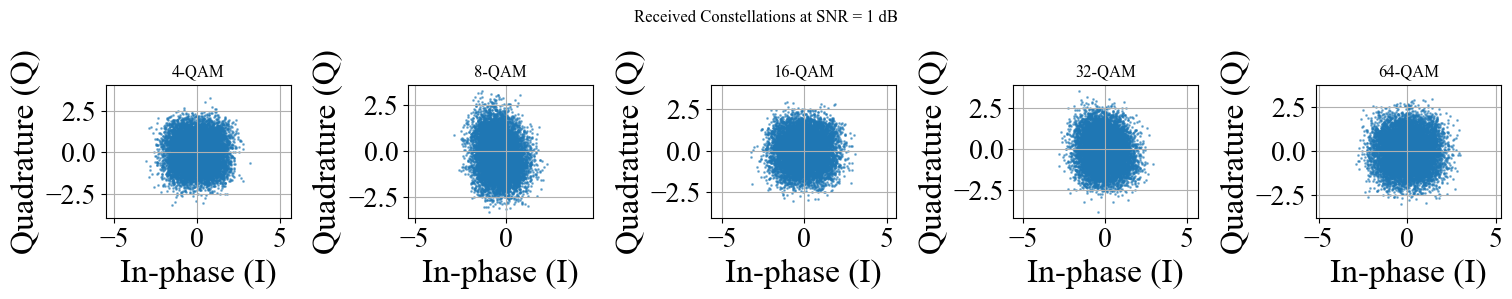


Simulating for SNR = 5 dB (noise_std = 0.3976)
  QAM-4: Average symbol power = 1.0000
  QAM-8: Average symbol power = 0.9920
  QAM-16: Average symbol power = 1.0104
  QAM-32: Average symbol power = 0.9945
  QAM-64: Average symbol power = 1.0042


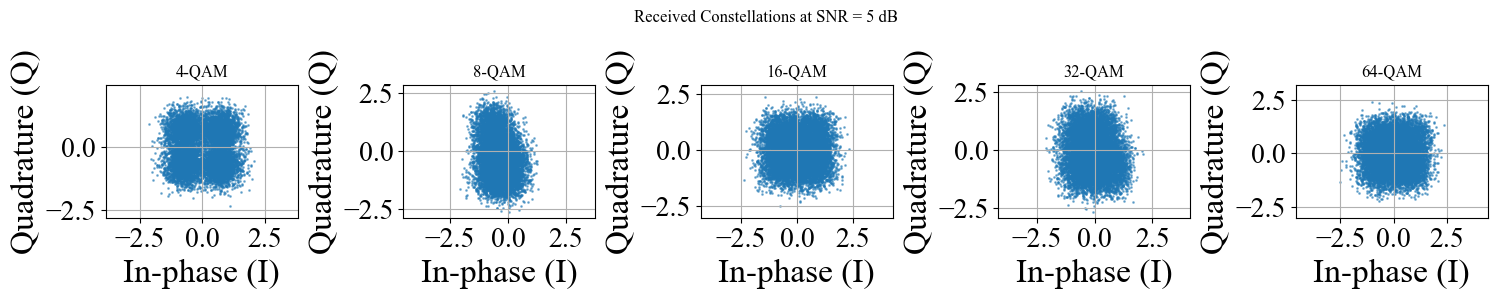


Simulating for SNR = 10 dB (noise_std = 0.2236)
  QAM-4: Average symbol power = 1.0000
  QAM-8: Average symbol power = 0.9961
  QAM-16: Average symbol power = 0.9970
  QAM-32: Average symbol power = 0.9949
  QAM-64: Average symbol power = 0.9984


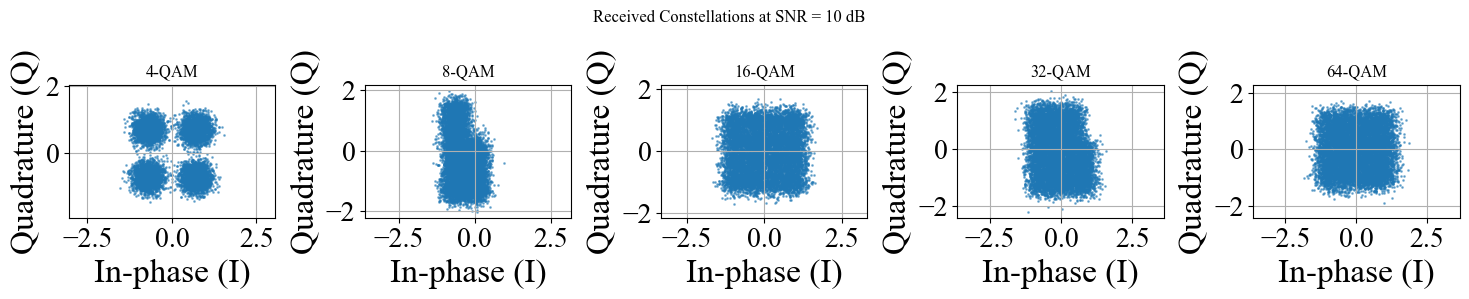


Simulating for SNR = 12 dB (noise_std = 0.1776)
  QAM-4: Average symbol power = 1.0000
  QAM-8: Average symbol power = 0.9945
  QAM-16: Average symbol power = 1.0006
  QAM-32: Average symbol power = 0.9923
  QAM-64: Average symbol power = 1.0146


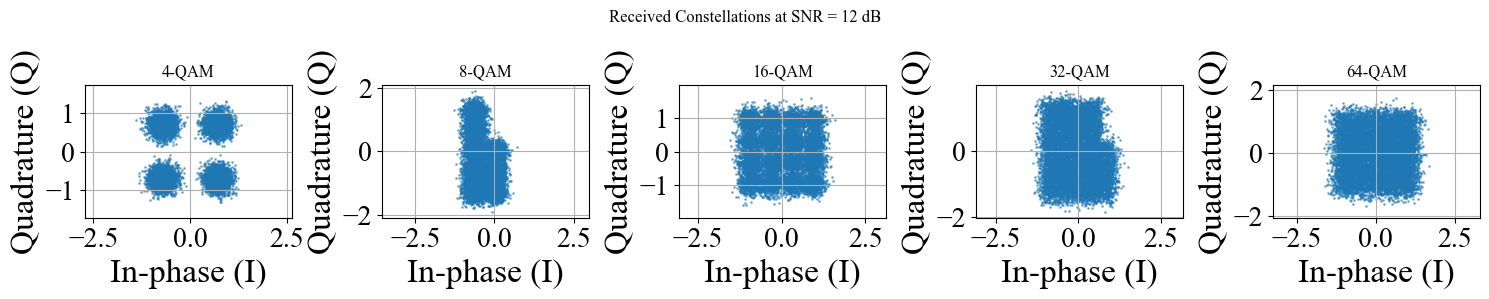


Simulating for SNR = 15 dB (noise_std = 0.1257)
  QAM-4: Average symbol power = 1.0000
  QAM-8: Average symbol power = 0.9986
  QAM-16: Average symbol power = 1.0062
  QAM-32: Average symbol power = 0.9936
  QAM-64: Average symbol power = 1.0052


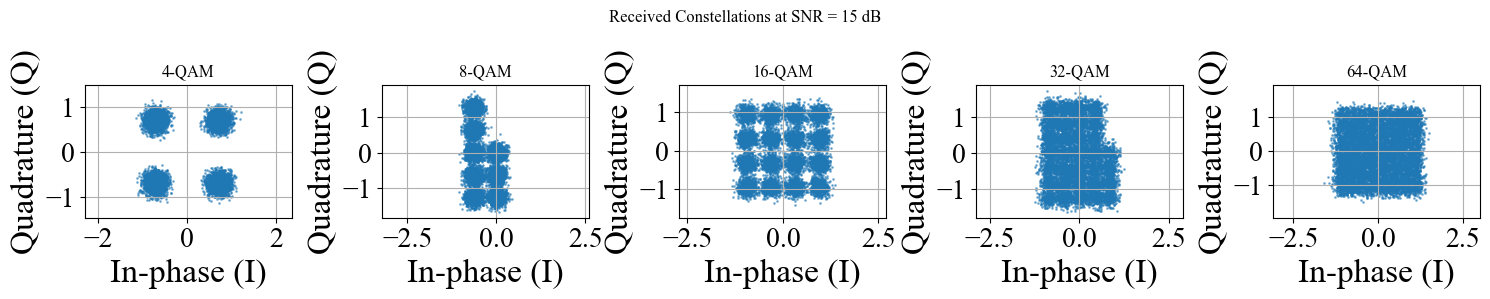


Simulating with random noise_val = 0.6125


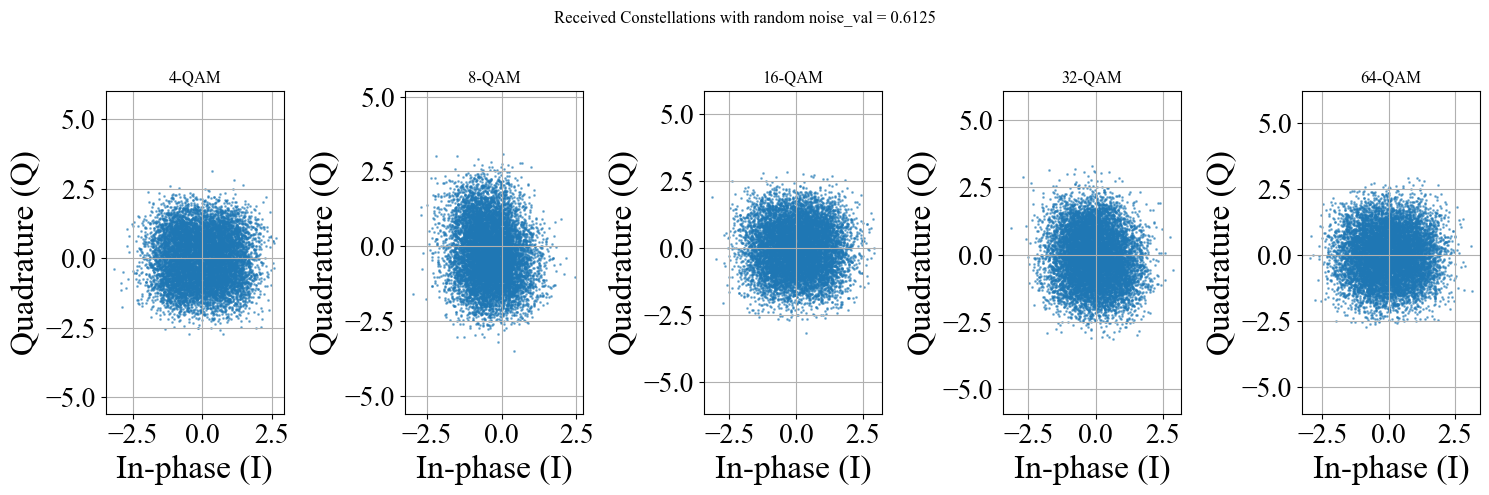

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from utils_oke import PowerNormalize, Channels, SNR_to_noise
# Channels class as provided

# Function to generate QAM constellation points normalized to unit average power
def get_qam_constellation(M):
    # Square QAM (M = 4, 16, 64, etc.)
    if math.isqrt(M)**2 == M:
        sqrtM = math.isqrt(M)
        d = torch.arange(-(sqrtM-1), sqrtM, 2, dtype=torch.float32)
        re, im = torch.meshgrid(d, d, indexing='ij')
        points_complex = re + 1j * im
    # Non-square QAM (e.g., 8-QAM, 32-QAM)
    else:
        # 8-QAM: Cross constellation (3 levels on I, 5 levels on Q, approximated)
        if M == 8:
            points = []
            levels = [-1, 0, 1]  # I components
            q_levels = [-2, -1, 0, 1, 2]  # Q components (cross-like)
            for i in levels:
                for q in q_levels:
                    if len(points) < M:
                        points.append(complex(i, q))
            points_complex = torch.tensor(points, dtype=torch.complex64)
        # 32-QAM: Cross or rectangular (5x7 grid, select 32 points)
        elif M == 32:
            points = []
            # Use a 5x7 grid and select 32 points (approximating cross 32-QAM)
            re = torch.tensor([-2, -1, 0, 1, 2], dtype=torch.float32)
            im = torch.tensor([-3, -2, -1, 0, 1, 2, 3], dtype=torch.float32)
            re, im = torch.meshgrid(re, im, indexing='ij')
            points_complex = (re + 1j * im).view(-1)
            # Select 32 points (e.g., remove corners to approximate cross)
            indices = torch.arange(35)  # 5x7 = 35 points
            points_complex = points_complex[indices[:32]]  # Take first 32
        else:
            raise ValueError(f"Unsupported QAM order: {M}")
    
    # Normalize to unit average energy
    avg_energy = torch.mean(torch.abs(points_complex)**2)
    points_complex /= torch.sqrt(avg_energy)
    return points_complex.view(-1)

# Simulation parameters
num_symbols = 10000  # Number of symbols to simulate
snr_db_values = [1,5,10,12, 15]  # Low and high SNR from your range
qam_orders = [4, 8, 16, 32, 64]  # Square (4, 16, 64) and non-square (8, 32) QAM
device = torch.device('cpu')  # or 'cuda' if available

# Instantiate the channel
chan = Channels()

# Loop over SNR values
for snr_db in snr_db_values:
    noise_std = SNR_to_noise(snr_db)
    print(f"\nSimulating for SNR = {snr_db} dB (noise_std = {noise_std:.4f})")
    
    # Create a figure for this SNR
    fig, axs = plt.subplots(1, len(qam_orders), figsize=(15, 3))
    fig.suptitle(f'Received Constellations at SNR = {snr_db} dB')
    
    # Loop over QAM orders
    for idx, M in enumerate(qam_orders):
        # Get constellation
        const = get_qam_constellation(M).to(device)
        
        # Generate random symbol indices
        indices = torch.randint(0, M, (num_symbols,), device=device)
        
        # Select symbols
        syms_complex = const[indices]
        
        # Convert to real-valued tensor [1, 2*num_symbols] (B=1)
        Tx = torch.stack((syms_complex.real, syms_complex.imag), dim=1).view(1, -1)
        
        # Confirm normalization
        avg_power = torch.mean(Tx**2) * 2  # Two components per symbol
        print(f"  QAM-{M}: Average symbol power = {avg_power.item():.4f}")
        
        # Apply AWGN channel
        sigma = torch.tensor(noise_std, dtype=torch.float32, device=device)
        Rx = chan.AWGN(Tx, sigma)
        
        # Extract received I and Q
        rx_i = Rx[0, 0::2].cpu().numpy()
        rx_q = Rx[0, 1::2].cpu().numpy()
        
        # Plot scatter
        axs[idx].scatter(rx_i, rx_q, s=1, alpha=0.5)
        axs[idx].set_title(f'{M}-QAM')
        axs[idx].set_xlabel('In-phase (I)')
        axs[idx].set_ylabel('Quadrature (Q)')
        axs[idx].grid(True)
        axs[idx].axis('equal')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Test with random noise_val as per your setup
noise_val = np.random.uniform(SNR_to_noise(1), SNR_to_noise(15))
print(f"\nSimulating with random noise_val = {noise_val:.4f}")
fig, axs = plt.subplots(1, len(qam_orders), figsize=(15, 5))
fig.suptitle(f"Received Constellations with random noise_val = {noise_val:.4f}")

for idx, M in enumerate(qam_orders):
    const = get_qam_constellation(M).to(device)
    indices = torch.randint(0, M, (num_symbols,), device=device)
    syms_complex = const[indices]
    Tx = torch.stack((syms_complex.real, syms_complex.imag), dim=1).view(1, -1)
    sigma = torch.tensor(noise_val, dtype=torch.float32, device=device)
    Rx = chan.AWGN(Tx, sigma)
    rx_i = Rx[0, 0::2].cpu().numpy()
    rx_q = Rx[0, 1::2].cpu().numpy()
    axs[idx].scatter(rx_i, rx_q, s=1, alpha=0.5)
    axs[idx].set_title(f'{M}-QAM')
    axs[idx].set_xlabel('In-phase (I)')
    axs[idx].set_ylabel('Quadrature (Q)')
    axs[idx].grid(True)
    axs[idx].axis('equal')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()